In [1]:
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math

Task 1. 데이터 준비하기

In [2]:
#Task 1-1
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
r = requests.get(url)
open("ml-latest-small.zip", "wb").write(r.content)
zipfile.ZipFile("ml-latest-small.zip").extractall()

#ratings 섞고 train, test 데이터 나눠줌
rating_data = pd.read_csv("/content/ml-latest-small/ratings.csv")
ratings_shuffled = rating_data.sample(frac=1)
train_len = int(len(ratings_shuffled)*0.8)
test_len = len(ratings_shuffled) - train_len

train = ratings_shuffled[:train_len]
train = train.reset_index()[['userId','movieId','rating','timestamp']]
test = ratings_shuffled[train_len:]
test = test.reset_index()[['userId','movieId','rating','timestamp']]

#Task 1-2 장르 집합으로 변환
movies = pd.read_csv("/content/ml-latest-small/movies.csv")
for i in range(len(movies["genres"])):
  genres = set()
  genres.update(movies['genres'][i].split('|'))
  movies['genres'][i] = genres


#Task 1-3
dic = {}
with open("/content/ml-latest-small/tags.csv") as f:
  for line in f:
    user, movie, tag, timestamp = line.split(',')
    tag = tag.lower()
    if movie=='movieId': continue
    if movie in dic:
      dic[movie].add(tag)
    else:
      dic[movie] = set()
      dic[movie].add(tag)

tagset = pd.DataFrame(list(dic.items()),
                   columns=['movieId', 'tags'])
tagset = tagset.astype({'movieId':'int'})
tagset = tagset.sort_values(by='movieId')
tagset = tagset.set_index('movieId')
tagset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,tags
movieId,
1,"{pixar, fun}"
2,"{magic board game, fantasy, game, robin williams}"
3,"{moldy, old}"
5,"{pregnancy, remake}"
7,{remake}
...,...
183611,"{rachel mcadams, comedy, funny}"
184471,"{alicia vikander, video game adaptation, adven..."
187593,"{josh brolin, sarcasm, ryan reynolds}"


Task 2. Latent Factor

epoch:0, cost:15.05475902557373, train_rmse: 3.5802141112761072, test_rmse:3.1445136596945895
epoch:100, cost:0.7817395925521851, train_rmse: 0.6481468974270435, test_rmse:0.8819519169475017
epoch:200, cost:0.7677628993988037, train_rmse: 0.6264164133596202, test_rmse:0.8744803315988536
epoch:300, cost:0.7650556564331055, train_rmse: 0.6212348777649798, test_rmse:0.871324825001859
epoch:400, cost:0.7641467452049255, train_rmse: 0.619317880762455, test_rmse:0.8711464014948187
epoch:500, cost:0.7637397646903992, train_rmse: 0.6183224154311333, test_rmse:0.8713691515564165
epoch:600, cost:0.7634740471839905, train_rmse: 0.6175937040174834, test_rmse:0.8712866189012122
epoch:700, cost:0.7632679343223572, train_rmse: 0.6169474412536241, test_rmse:0.8707774319266427
epoch:800, cost:0.7631462216377258, train_rmse: 0.6164770987326254, test_rmse:0.870251543523115
epoch:900, cost:0.7630924582481384, train_rmse: 0.6162608469536558, test_rmse:0.8699271768477757
epoch:1000, cost:0.7630694508552551,

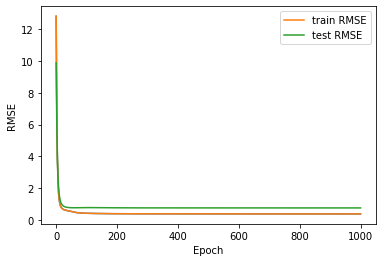

In [3]:
#필요한 데이터
items = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movieId'])
users_test = torch.LongTensor(test['userId'])
ratings_test = torch.FloatTensor(test['rating'])


rank = 10
num_users = users.max()+1
num_items = items.max()+1

P = torch.randn(num_users, rank, requires_grad=True)
Q = torch.randn(num_items, rank, requires_grad=True)

#bias
bias_user = torch.randn(num_users, requires_grad = True)
bias_item = torch.randn(num_items, requires_grad = True) 
mean = (ratings.sum()/ len(ratings)).item()


lambda_P = 0.0001
lambda_Q = 0.0001
lambda_BU = 0.0001
lambda_BI = 0.0001


optimizer = torch.optim.Adam([P,Q, bias_item, bias_user], lr=0.1)

X = []
Y = []
Y_test = []
for epoch in range(1001):
  hypo = (P[users] * Q[items]).sum(dim=1) + bias_user[users] + bias_item[items] + mean
  mse = F.mse_loss(hypo, ratings)
  #Regularization
  cost = mse + lambda_P * (P**2).sum() + lambda_Q * (Q**2).sum() + \
            lambda_BU * (bias_user**2).sum() + lambda_BI * (bias_item**2).sum()

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(mse.item())

    hypo_test = (P[users_test] * Q[items_test]).sum(dim=1) + \
                + bias_user[users_test] + bias_item[items_test] + mean
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test)

    if epoch % 100 == 0:
      print(f"epoch:{epoch}, cost:{cost**0.5}, train_rmse: {mse.item()**0.5}, test_rmse:{mse_test.item()**0.5}")



plt.plot(X,Y)
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.plot(X, Y, label="train RMSE")
plt.plot(X, Y_test, label="test RMSE")
plt.legend()
plt.show()





Hyper parameter 탐색
epoch:0, cost:14.445600509643555, train_rmse: 3.613698244519236, test_rmse:3.5770945835251355
epoch:100, cost:6.481698989868164, train_rmse: 1.248137803563601, test_rmse:1.869720528470429
epoch:200, cost:3.2751359939575195, train_rmse: 0.8022287080149768, test_rmse:1.560668329470755
epoch:300, cost:2.0161237716674805, train_rmse: 0.6752971613182172, test_rmse:1.4815914356083026
epoch:400, cost:1.599923014640808, train_rmse: 0.6195689263258256, test_rmse:1.4645260072054882
epoch:500, cost:1.4813874959945679, train_rmse: 0.5856128047296212, test_rmse:1.4665319048496335
epoch:600, cost:1.4463647603988647, train_rmse: 0.5619105588547167, test_rmse:1.4757597825289794
epoch:700, cost:1.4331188201904297, train_rmse: 0.5441787739215445, test_rmse:1.4877160468402568
epoch:800, cost:1.4260516166687012, train_rmse: 0.530267620581657, test_rmse:1.5009812483407257
epoch:900, cost:1.4212018251419067, train_rmse: 0.5189740053513646, test_rmse:1.5149786445950655
epoch:1000, cost:1.4

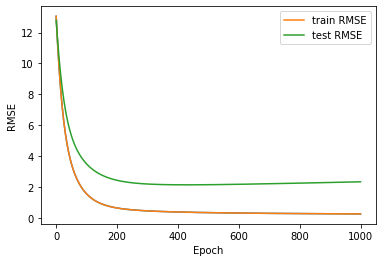

In [4]:
print("Hyper parameter 탐색")
#hyper parameter 탐색
#learning rate, regularization weight 변화

rank = 10
num_users = users.max()+1
num_items = items.max()+1

P_t = torch.randn(num_users, rank, requires_grad=True)
Q_t = torch.randn(num_items, rank, requires_grad=True)

#bias
bias_user = torch.randn(num_users, requires_grad = True)
bias_item = torch.randn(num_items, requires_grad = True) 
mean = (ratings.sum()/ len(ratings)).item()


lambda_P = 0.001
lambda_Q = 0.001
lambda_BU = 0.001
lambda_BI = 0.001


optimizer_ = torch.optim.Adam([P_t,Q_t,bias_item, bias_user], lr=0.01)

X = []
Y = []
Y_test = []
for epoch in range(1001):
  hypo = (P_t[users] * Q_t[items]).sum(dim=1) + bias_user[users] + bias_item[items] + mean
  mse = F.mse_loss(hypo, ratings)
  #Regularization
  cost = mse + lambda_P * (P**2).sum() + lambda_Q * (Q**2).sum() + \
            lambda_BU * (bias_user**2).sum() + lambda_BI * (bias_item**2).sum()

  optimizer_.zero_grad()
  cost.backward()
  optimizer_.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(mse.item())

    hypo_test = (P_t[users_test] * Q_t[items_test]).sum(dim=1) + \
                + bias_user[users_test] + bias_item[items_test] + mean
    mse_test = F.mse_loss(hypo_test, ratings_test)
    Y_test.append(mse_test)

    if epoch % 100 == 0:
      print(f"epoch:{epoch}, cost:{cost**0.5}, train_rmse: {mse.item()**0.5}, test_rmse:{mse_test.item()**0.5}")



plt.plot(X,Y)
plt.xlabel("Epoch")
plt.ylabel("RMSE")

plt.plot(X, Y, label="train RMSE")
plt.plot(X, Y_test, label="test RMSE")
plt.legend()

plt.show()


Task 3. Knn search , similarity


In [5]:
def jaccard_similarity(s1,s2):
  if len(s1|s2) == 0:
    return 0
  return len(s1&s2) / len(s1|s2)

def pearson_similarity(u1,u2):
  u1_c = u1 - u1.mean()
  u2_c = u2 - u2.mean()
  denom = np.sqrt(np.sum(u1_c ** 2) * np.sum(u2_c ** 2))
  if denom != 0:
    return np.sum(u1_c * u2_c) / denom
  else:
    return 0

In [7]:
movieTitle = movies[['movieId', 'title']]
rating_titled = pd.merge(rating_data, movieTitle, on='movieId', how='inner')

user514_rating = rating_titled[rating_titled['userId'] == 514].reset_index(drop=True)
fivePoints = user514_rating.loc[user514_rating['rating'] == 5.0, :]['title'].tolist()

merged = pd.merge(movies, tagset, on='movieId', how='outer')
merged['tags'] = merged['tags'].apply(lambda d: d if isinstance(d, set) else set())

matrix = rating_titled.pivot_table(index='userId', columns='title', values='rating')

In [35]:
#Latent Factor Model로 얻은 514번 유저 예상 별점
l = []

for i in movies['movieId']:
  l.append([torch.sum(P[514] * Q[i]).item(), i])
l = sorted(l, reverse=True)

user514_list = []
for r, movieId in l[:20]:
  user514_list.append((movieId, movieTitle[movieTitle['movieId'] == movieId].values[0][1])) 
user514_df = pd.DataFrame(user514_list, columns=['movieId','title'])

user514_df

,movieId,title
0,527,Schindler's List (1993)
1,318,"Shawshank Redemption, The (1994)"
2,1203,12 Angry Men (1957)
3,593,"Silence of the Lambs, The (1991)"
4,260,Star Wars: Episode IV - A New Hope (1977)
5,1387,Jaws (1975)
6,2028,Saving Private Ryan (1998)
7,589,Terminator 2: Judgment Day (1991)
8,1097,E.T. the Extra-Terrestrial (1982)
9,1036,Die Hard (1988)


In [36]:
def find_similar_movies(input_title, matrix, merged, alpha = 0.5):
  input_vector = matrix[input_title]
  input_meta = merged.loc[merged['title'] == input_title, :].iloc[0,:]
  
  input_set = input_meta['genres'] | input_meta['tags']
  
  results = []
  alpha = 0.5

  for this_title in matrix.columns:
    if(input_title == this_title):
      continue

    this_vector = matrix[this_title]
    this_meta = merged.loc[merged['title'] == this_title, :].iloc[0,:]
    this_set = this_meta['genres']
  
    this_set = this_meta['genres'] | this_meta['tags']

    jaccard = jaccard_similarity(input_set, this_set)
    pearson = pearson_similarity(input_vector, this_vector)

    score = alpha * jaccard + (1-alpha) * pearson
    results.append((this_meta[0], this_title, score))

  results.sort(key=lambda item: item[2], reverse=True)
  print(input_meta[0], input_title)
  return pd.DataFrame(results[:5], columns=['movieId','title', 'score'])

for i in fivePoints:
  print(find_similar_movies(i,matrix, merged, 0.5))


260 Star Wars: Episode IV - A New Hope (1977)
   movieId                                              title     score
0     1196  Star Wars: Episode V - The Empire Strikes Back...  0.414028
1     1210  Star Wars: Episode VI - Return of the Jedi (1983)  0.409372
2     2571                                 Matrix, The (1999)  0.169033
3      480                               Jurassic Park (1993)  0.168316
4    60514          Journey to the Center of the Earth (2008)  0.164208
593 Silence of the Lambs, The (1991)
   movieId                   title     score
0     6952          Gothika (2003)  0.227664
1    53953             1408 (2007)  0.220317
2    90345       Thing, The (2011)  0.217607
3     3535  American Psycho (2000)  0.216595
4   166534            Split (2017)  0.213887
1196 Star Wars: Episode V - The Empire Strikes Back (1980)
   movieId                                              title     score
0      260          Star Wars: Episode IV - A New Hope (1977)  0.414028
1     1210  

Task 4. K-means clustering

In [53]:
ratinged_movieId_set = set()

for i in rating_data['movieId']:
  ratinged_movieId_set.add(i)

ratinged_movieid_list = sorted(list(ratinged_movieId_set))

movie_vector = []
for i in ratinged_movieid_list:
  movie_vector.append(Q[i].detach().numpy().tolist())

raw_data = {'movieId': ratinged_movieid_list,
            'movie_v': movie_vector}

Q_ratinged = pd.DataFrame(raw_data)
Q_ratinged

,movieId,movie_v
0,1,"[-0.0625951811671257, 0.06168224290013313, -0...."
1,2,"[-0.1837041676044464, -0.0595073364675045, -0...."
2,3,"[-0.33636653423309326, -0.2425922304391861, -0..."
3,4,"[-0.0009417427354492247, 0.015733301639556885,..."
4,5,"[-0.2889902889728546, -0.05499204993247986, -0..."
...,...,...
9719,193581,"[-0.0001668726617936045, -0.006522325798869133..."
9720,193583,"[7.622776320204139e-05, 0.00297642988152802, -..."
9721,193585,"[7.667046156711876e-05, 0.0029764841310679913,..."
9722,193587,"[7.678479596506804e-05, 0.0029766387306153774,..."


In [51]:
def cos_similarity(a, b):
  return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

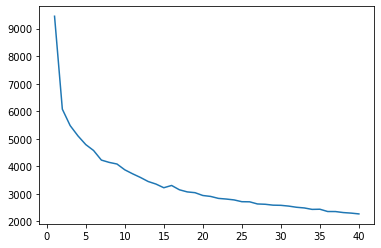

In [54]:
#거리 - > 코사인 similarity
#max_iter을 20~30번 정도 돌리면 centorids를 찾아주긴 하는데
#시간이 너무 오래걸리고, 10번 돌린 것과 크게 차이가 나지 않는 것 같아 max_iter을 10으로 정했습니다.

def kmeans(points, k, max_iters=10):
  n_points = points.shape[0]
  cluster_centers = points[np.random.choice(n_points, k, replace=False)]
  for iter in range(max_iters):
    labels = []
    for p in points:
      min_dist = np.inf
      min_cid = -1
      for cid, c in enumerate(cluster_centers):
        dist = 1 - cos_similarity(p,c)
        if dist < min_dist:
          min_dist = dist
          min_cid = cid
      labels.append(min_cid)
    labels = np.array(labels)
    new_cluster_centers = np.zeros_like(cluster_centers)
    counts = np.zeros(k)

    #centorid vector 크기를 1로 만들어준다.
    for l, p in zip(labels, points):
      new_cluster_centers[l] += p

    for i in range(k):
      new_cluster_centers_size = np.sum(new_cluster_centers[i]**2)**0.5
      new_cluster_centers[i] /= new_cluster_centers_size

    if np.array_equal(cluster_centers,new_cluster_centers):
      break;
    else :
      cluster_centers = new_cluster_centers
  
  #cost 계산
  cost = 0
  for i in range(len(points)):
    cost += 1- cos_similarity(points[i] , cluster_centers[labels[i]])

  return labels, cluster_centers, cost

#cost 그래프

p = []
for i in Q_ratinged['movie_v']:
  p.append(i)
p_array = np.array(p)

cost_x = [i for i in range(1,41)]
cost_list = []
for i in range(1,41):
  labels, cluster_centers, cost = kmeans(p_array,i)
  cost_list.append(cost)

plt.plot(cost_x, cost_list)
plt.show()

In [92]:
#Task 4_3 
labels_kmean, cluster_centers_kmean, cost_kmean = kmeans(p_array,5)
Q_ratinged['label'] = labels_kmean


the_label = Q_ratinged[Q_ratinged['movieId']==122912]['label']
v = Q_ratinged[Q_ratinged['movieId'] ==122912]['movie_v'].item()
same_labels = Q_ratinged[Q_ratinged['label'] == int(the_label)]
same_labels = pd.merge(same_labels,movieTitle, how="inner", on='movieId')

cos = []
for i in same_labels['movie_v']:
  cos.append(cos_similarity(v, i))

same_labels['cosine_similarity'] = cos

task4_3 = same_labels.sort_values('cosine_similarity', ascending=False)[1:21][['movieId','title','cosine_similarity']]
task4_3

,movieId,title,cosine_similarity
1490,122916,Thor: Ragnarok (2017),0.903430
1454,115149,John Wick (2014),0.867003
1285,80124,Sisters (Syostry) (2001),0.831641
1491,122922,Doctor Strange (2016),0.831570
188,1321,"American Werewolf in London, An (1981)",0.825682
73,407,In the Mouth of Madness (1995),0.796398
555,3896,"Way of the Gun, The (2000)",0.795357
1327,89745,"Avengers, The (2012)",0.790361
1247,71264,Cloudy with a Chance of Meatballs (2009),0.784718
808,6196,Cradle 2 the Grave (2003),0.783948


Task 5. PCA

In [62]:
def findPC(Z):
  dim = Z.shape[1]
  w = torch.randn(dim)
  w = w / ((w**2).sum() ** 0.5)

  lr = 0.1

  for epoch in range(101):
    w.requires_grad_(True)

    variance = ((Z @ w.view(-1,1)) ** 2).mean()
    variance.backward(retain_graph=True )

    with torch.no_grad():
      w = w + lr* w.grad
      w = w / ((w**2).sum()**0.5)
      
  return w, variance.item()


def PCA(Z, n):
  W = []
  V = []

  for _ in range(n):
    w, v = findPC(Z)
    W.append(w)
    V.append(v)
    Z = Z - (Z @ w.view(-1,1)) * w
  return W, V

def transform(Z,W):
  return Z @ torch.stack(W).T

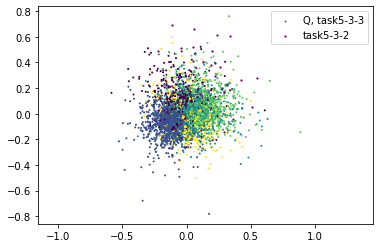

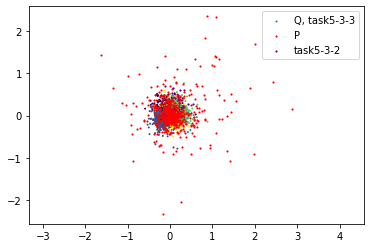

In [100]:
q_ratinged = Q_ratinged['movie_v'].tolist()
q_tensor = torch.tensor(q_ratinged)
Z_ = torch.cat([q_tensor, P], dim=0)
id_list = []
for p, id in l[:20]:
  id_list.append(id)

#PCA
X_ = Z_
Z_ = X_ - X_.mean(dim=0)

W_, V_ = PCA(Z_,10)
Zt_ = transform(Z_,W_)


x = Zt_[:,0].detach().numpy()
y = Zt_[:,1].detach().numpy()

p_x = x[-611:]
p_y = y[-611:]
q_x = []
q_y = []
q_list = []
t_x = []
t_y = []

for i in range(len(Q_ratinged)):
  if Q_ratinged['movieId'][i] in id_list:
    t_x.append(x[i])
    t_y.append(y[i])
  else:
    q_list.append(Q_ratinged['label'][i])
    q_x.append(x[i])
    q_y.append(y[i])


plt.scatter(q_x, q_y, s=1 , c=q_list , label='Q, task5-3-3')
#plt.scatter(p_x,p_y, s=1.25, c='red', label='P')
plt.scatter(t_x,t_y, s=1.5, c='purple', label='task5-3-2')
plt.axis("equal")
plt.legend()
plt.show()

#P 때문에 잘 안보여서 두 개로 구분했습니다.
plt.scatter(q_x, q_y, s=1 , c=q_list , label='Q, task5-3-3')
plt.scatter(p_x,p_y, s=1.25, c='red', label='P')
plt.scatter(t_x,t_y, s=1.5, c='purple', label='task5-3-2')
plt.axis("equal")
plt.legend()
plt.show()